In [1]:
import os
import warnings
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.preprocessing import OrdinalEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.cluster import KMeans

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from xgboost import XGBRegressor

# Setup feedback system
from learntools.core import binder
binder.bind(globals())
from learntools.feature_engineering_new.ex2 import *

import seaborn as sns
from sklearn.feature_selection import mutual_info_regression

<h2>Utility functions</h2>

In [2]:
# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)

# Utility functions from Tutorial
def make_mi_scores(X, y):
    X = X.copy()
    for colname in X.select_dtypes(["object", "category"]):
        X[colname], _ = X[colname].factorize()
    # All discrete features should now have integer dtypes
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features, random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores


def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")



def get_mae(max_leaf_nodes, train_X, val_X, train_y, val_y):
    model = DecisionTreeRegressor(max_leaf_nodes=max_leaf_nodes, random_state=0)
    model.fit(train_X, train_y)
    preds_val = model.predict(val_X)
    mae = mean_absolute_error(val_y, preds_val)
    return(mae)

def score_dataset(X, y, model=XGBRegressor()):
    # Label encoding for categoricals
    for colname in X.select_dtypes(["category", "object"]):
        X[colname], _ = X[colname].factorize()
    # Metric for Housing competition is RMSLE (Root Mean Squared Log Error)
    score = cross_val_score(
        model, X, y, cv=5, scoring="neg_mean_squared_log_error",
    )
    score = -1 * score.mean()
    score = np.sqrt(score)
    return score

def get_score(n_estimators):
    """Return the average MAE over 3 CV folds of random forest model.
    
    Keyword argument:
    n_estimators -- the number of trees in the forest
    """
    my_pipeline = Pipeline(steps=[
        ('preprocessor', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)),
        ('model', RandomForestRegressor(n_estimators=n_estimators, random_state=0))
    ])
    scores = -1 * cross_val_score(my_pipeline, X_train, y_train,
                              cv=3,
                              scoring='neg_mean_absolute_error')
    return scores.mean()



/tmp/ipykernel_13/3880581003.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")


<h2>Reading the data and preprocessing</h2>

In [3]:
#Read data
# Read the data
X_full = pd.read_csv('/kaggle/input/playground-series-s4e4/train.csv', index_col='id')
X_test_full = pd.read_csv('/kaggle/input/playground-series-s4e4/test.csv', index_col='id')
X_full_copy = X_full.copy()
# Remove rows with missing target, separate target from predictors
X_full.dropna(axis=0, subset=['Rings'], inplace=True)
y = X_full.Rings
X_full.drop(['Rings'], axis=1, inplace=True)

array([[<Axes: title={'center': 'Length'}>,
        <Axes: title={'center': 'Diameter'}>,
        <Axes: title={'center': 'Height'}>],
       [<Axes: title={'center': 'Whole weight'}>,
        <Axes: title={'center': 'Whole weight.1'}>,
        <Axes: title={'center': 'Whole weight.2'}>],
       [<Axes: title={'center': 'Shell weight'}>,
        <Axes: title={'center': 'Rings'}>, <Axes: >]], dtype=object)

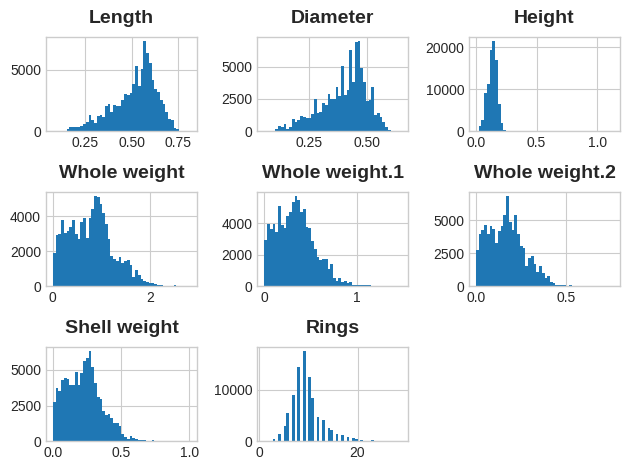

In [4]:
X_full_copy.hist(bins=50)

<h2>Feature engineering (No need extensive for data processing)</h2>

In [5]:
X_full["Total Size"] = (4*np.pi)*(X_full["Height"]*X_full["Length"]*X_full["Diameter"])/3
X_test_full["Total Size"] = (4*np.pi)*(X_full["Height"]*X_full["Length"]*X_full["Diameter"])/3
X_full_copy["Total Size"] = (4*np.pi)*(X_full["Height"]*X_full["Length"]*X_full["Diameter"])/3
mi_scores = make_mi_scores(X_full, y)

Shell weight      0.679544
Total Size        0.583046
Whole weight      0.574641
Height            0.556323
Diameter          0.546853
Whole weight.2    0.544125
Length            0.533280
Whole weight.1    0.509264
Sex               0.243144
Name: MI Scores, dtype: float64


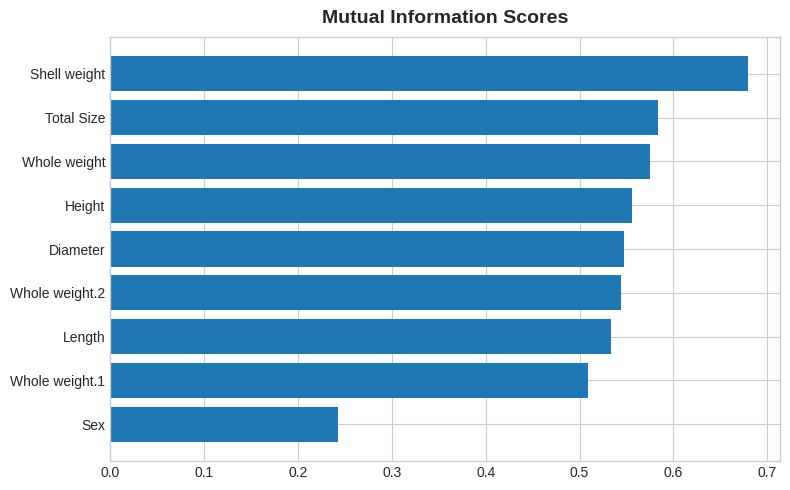

In [6]:
print(mi_scores.head(20))
# print(mi_scores.tail(20))  # uncomment to see bottom 20

plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores.head(20))
# plot_mi_scores(mi_scores.tail(20))  # uncomment to see bottom 20

In [7]:
# List of features you want to plot against "Rings"
features = ["Shell weight", "Whole weight", "Total Size"]

# Loop through each feature and generate the lmplot
"""
for feature in features:
    sns.lmplot(
        x=feature, y="Rings", hue="Sex", col="Sex",
        data=X_full_copy, scatter_kws={"edgecolor": 'w'}, col_wrap=3, height=4
    )
    plt.suptitle(f'Regression of {feature} on Rings by Sex', y=1.05)
    plt.show()
"""


'\nfor feature in features:\n    sns.lmplot(\n        x=feature, y="Rings", hue="Sex", col="Sex",\n        data=X_full_copy, scatter_kws={"edgecolor": \'w\'}, col_wrap=3, height=4\n    )\n    plt.suptitle(f\'Regression of {feature} on Rings by Sex\', y=1.05)\n    plt.show()\n'

In [8]:
"""
# One-hot encode the 'Sex' column
X_full_copy = pd.get_dummies(X_full_copy, columns=['Sex'], drop_first=True)

# Now we have Sex_M and Sex_I (Sex_F is dropped due to drop_first=True)
# Create the interaction terms between each Sex category and Whole weight
X_full_copy['Sex_M_WholeWeight_Interaction'] = X_full_copy['Sex_M'] * X_full_copy['Whole weight']
X_full_copy['Sex_I_WholeWeight_Interaction'] = X_full_copy['Sex_I'] * X_full_copy['Whole weight']

# Check the new dataframe with the interaction terms
print(X_full_copy[['Sex_M', 'Sex_I', 'Whole weight', 'Sex_M_WholeWeight_Interaction', 'Sex_I_WholeWeight_Interaction']].head())

"""


"\n# One-hot encode the 'Sex' column\nX_full_copy = pd.get_dummies(X_full_copy, columns=['Sex'], drop_first=True)\n\n# Now we have Sex_M and Sex_I (Sex_F is dropped due to drop_first=True)\n# Create the interaction terms between each Sex category and Whole weight\nX_full_copy['Sex_M_WholeWeight_Interaction'] = X_full_copy['Sex_M'] * X_full_copy['Whole weight']\nX_full_copy['Sex_I_WholeWeight_Interaction'] = X_full_copy['Sex_I'] * X_full_copy['Whole weight']\n\n# Check the new dataframe with the interaction terms\nprint(X_full_copy[['Sex_M', 'Sex_I', 'Whole weight', 'Sex_M_WholeWeight_Interaction', 'Sex_I_WholeWeight_Interaction']].head())\n\n"

In [9]:
X_features = X_full_copy.loc[:, features]
kmeans = KMeans(n_clusters=10, n_init=10, random_state=0)
X_full_copy["Cluster"] = kmeans.fit_predict(X_features)

X_full_copy.head()


,Sex,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight,Rings,Total Size,Cluster
id,,,,,,,,,,,
0,F,0.550,0.430,0.150,0.7715,0.3285,0.1465,0.2400,11,0.148597,6
1,F,0.630,0.490,0.145,1.1300,0.4580,0.2765,0.3200,11,0.187497,7
2,I,0.160,0.110,0.025,0.0210,0.0055,0.0030,0.0050,6,0.001843,3
3,M,0.595,0.475,0.150,0.9145,0.3755,0.2055,0.2500,10,0.177579,2
4,I,0.555,0.425,0.130,0.7820,0.3695,0.1600,0.1975,9,0.128444,6


/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


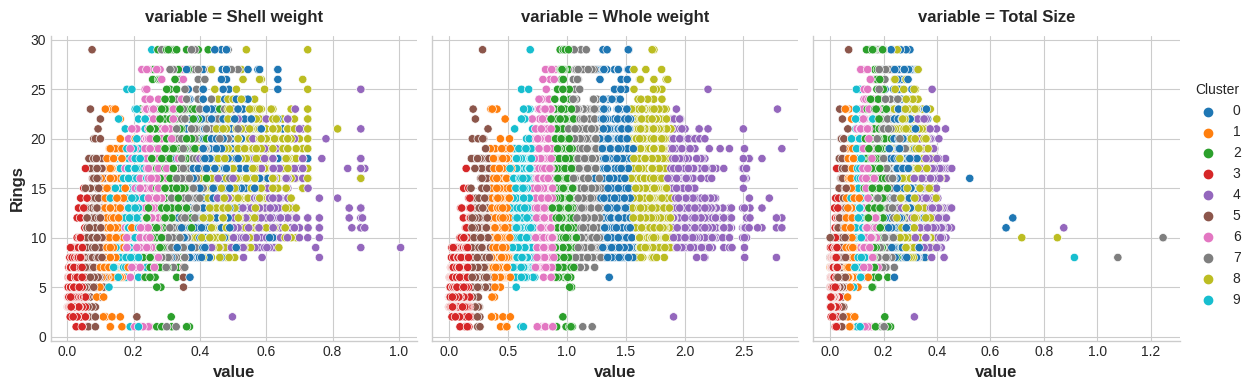

In [10]:
Xy = X_full_copy.copy()
Xy["Cluster"] = Xy.Cluster.astype("category")
Xy["SalePrice"] = y
sns.relplot(
    x="value", y="Rings", hue="Cluster", col="variable",
    height=4, aspect=1, facet_kws={'sharex': False}, col_wrap=3,
    data=Xy.melt(
        value_vars=features, id_vars=["Rings", "Cluster"],
    ),
);


In [11]:
#Break off validation set from training data
X_train, X_valid, y_train, y_valid = train_test_split(X_full, y, train_size=0.8, test_size=0.2,
                                                      random_state=0)

In [12]:
score_dataset(X_full, y)

0.1512916569359362

In [13]:
model_XGB = XGBRegressor(random_state=0)


In [14]:
# Create the pipeline
final_pipeline = Pipeline(steps=[
    ('preprocessor', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)),
    ('model', model_XGB)
])


<h1>Train a model for the competion</h1>

In [15]:
final_pipeline.fit(X_full, y)
# 2. Select numeric columns from the test data
test_preds = final_pipeline.predict(X_test_full)
# 3. Make predictions on the test data
# 4. Create the output DataFrame for submission
output = pd.DataFrame({'id': X_test_full.index, 
                       'Rings': test_preds})

# 5. Save the predictions to a CSV file for submission
output.to_csv('submission.csv', index=False)

print("Predictions saved to 'submission.csv'")

Predictions saved to 'submission.csv'
